Regional model analysis


In [1]:
import numpy as np
import os
import netCDF4
from matplotlib import pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DayLocator, HourLocator, DateFormatter, drange
from matplotlib.colors import LogNorm

import dateutil.parser
%matplotlib inline

In [2]:
def concat_rgcm(indir, varss):
    #indir = '/data/jialiwang/WRF-CCSM_BC/'
    all_files = os.listdir(indir)
    #print(all_files)
    sgp_files = []
    for fil in all_files:
        if 'SGP.nc' in fil:
            sgp_files.append(fil)
    sgp_files.sort()
    for i in range(len(sgp_files)):
        #print(sgp_files[i])
        test_dataset = netCDF4.Dataset(indir+sgp_files[i])
        all_rain = np.zeros(test_dataset.variables[varss[0]][:].shape)
        for vss in varss:
            all_rain = all_rain + test_dataset.variables[vss][:]
        mean_accum = all_rain.mean(axis = 1).mean(axis =1 )
        mean_accum[np.where(mean_accum < 0.0)] = 0.
        #seconds since 2006-01-19T07:50:09Z
        datestr = 'hours since '+sgp_files[i][0:4]+'-01-01T00:00:00Z'
        hours_since_start_of_year = (np.arange(len(mean_accum)) + 1.)*3.0
        dt_array = netCDF4.num2date(hours_since_start_of_year, datestr)
        test_dataset.close()
        if i == 0 :
            all_rains = mean_accum/3.0
            all_times = dt_array
        else:
            all_rains = np.append(all_rains, mean_accum/3.0)
            all_times = np.append(all_times, dt_array)
    return all_rains, all_times

def rain_plotter(all_times, all_rains):
    fig = plt.figure(figsize = [15,6])
    plt.plot(mdates.date2num(all_times), all_rains, 'b-', label = 'mean')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MonthLocator(interval = 6))
    #ax.xaxis.set_minor_locator(HourLocator(np.arange(0, 25, 6)))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

    ax.fmt_xdata = DateFormatter('%Y-%m')
    fig.autofmt_xdate()

    cnt = plt.gcf()
    fig.autofmt_xdate()
    plt.ylabel('Domain mean rain rate (mm/h)', size = 20)
    plt.legend(loc = 2)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)

def hourly_stats(all_times, all_rains, hours):
    boxed_means_hours = []
    for hour in hours:
        foo = [ a.hour == hour for a in all_times]
        boxed_means_hours.append(all_rains[np.where(foo)])
    hrly = np.array([a.mean() for a in boxed_means_hours])
    nbins = 50
    rr = (0.05, 3)
    hist_rf = np.zeros([len(hours), nbins])
    for i in range(len(hours)):
        bine = np.histogram(boxed_means_hours[i], bins=nbins, range= rr)[1]
        hist_rf[i,:] = np.histogram(boxed_means_hours[i], bins=nbins, range= rr)[0]
    hrly = np.array([a.mean() for a in boxed_means_hours])
    hrly50 = np.array([np.percentile(a, 50) for a in boxed_means_hours])
    hrly25 = np.array([np.percentile(a, 25) for a in boxed_means_hours])
    hrly75 = np.array([np.percentile(a, 75) for a in boxed_means_hours])
    return hist_rf, bine , (hrly, hrly50, hrly25, hrly75)

def monthly_stats(all_times, all_rains, months):
    boxed_means_months = []
    months = np.linspace(1,12,12)
    boxed_means_months = []
    for month in months:
        foo = [ a.month == month for a in all_times]
        boxed_means_months.append(all_rains[np.where(foo)])
    monthly = np.array([a.mean() for a in boxed_means_months])
    nbins = 50
    rr = (0.05, 3)
    hist_rf_monthly = np.zeros([len(months), nbins])
    for i in range(len(months)):
        bine2 = np.histogram(boxed_means_months[i], bins=nbins, range= rr)[1]
        hist_rf_monthly[i,:] = np.histogram(boxed_means_months[i], bins=nbins, range= rr)[0]
    monthly = np.array([a.mean() for a in boxed_means_months])
    monthly50 = np.array([np.percentile(a, 50) for a in boxed_means_months])
    monthly25 = np.array([np.percentile(a, 25) for a in boxed_means_months])
    monthly75 = np.array([np.percentile(a, 75) for a in boxed_means_months])
    return hist_rf_monthly, bine2, (monthly, monthly50, monthly25, monthly75)



In [3]:
hours = np.arange(8) *3.
lt = (hours - 6) % 24
lts = ["%d" % a for a in lt] 
months = np.linspace(1,12,12)

In [4]:
all_rains_CCSM_BC, all_times_CCSM_BC = \
           concat_rgcm('/data/jialiwang/WRF-CCSM_BC/', ['rain_tot'])
    
hist_rf, bine, (hrly, hrly50, hrly25, hrly75) = \
          hourly_stats(all_times_CCSM_BC, all_rains_CCSM_BC, hours)

hist_rf_monthly, bine2, (monthly, monthly50, monthly25, monthly75) = \
        monthly_stats(all_times_CCSM_BC, all_rains_CCSM_BC, months)

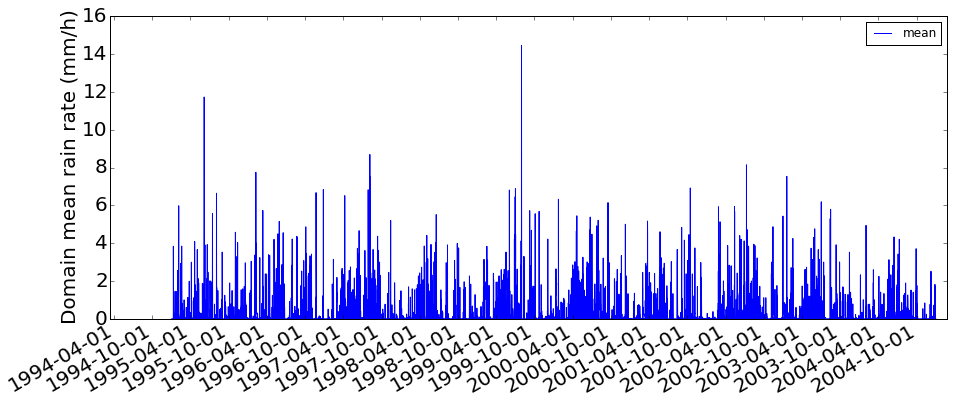

In [5]:
rain_plotter(all_times_CCSM_BC, all_rains_CCSM_BC)

<matplotlib.colorbar.Colorbar instance at 0x109e0a368>

/Users/scollis/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


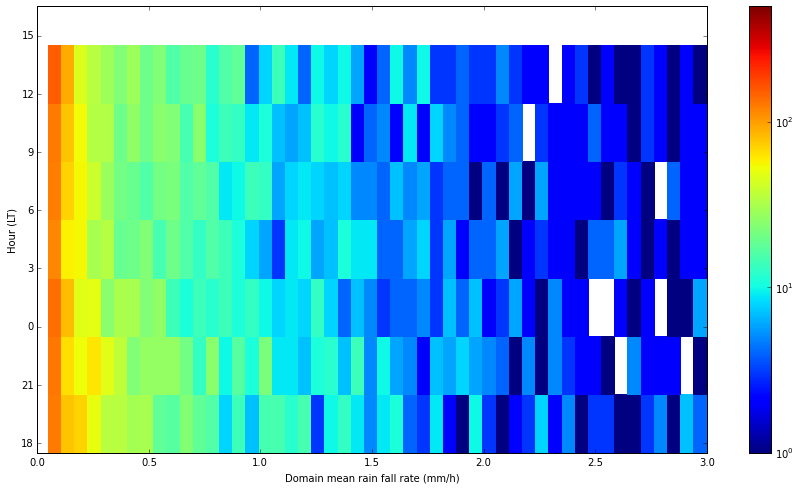

In [6]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine, hours, hist_rf, norm=LogNorm(vmin=1, vmax=500))
ax = plt.gca()
mty = plt.yticks(hours+.5, lts)
plt.ylim([0,23])
plt.ylabel('Hour (LT)')
plt.xlabel('Domain mean rain fall rate (mm/h)')
plt.colorbar()

(1, 12)

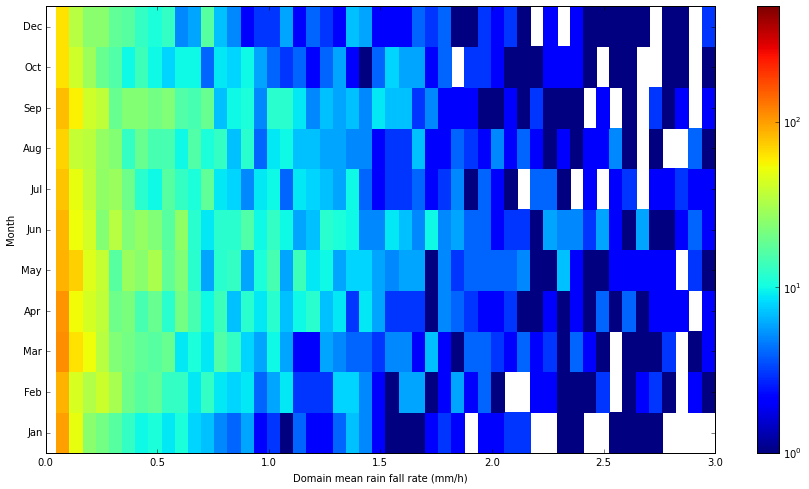

In [7]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine2, months, hist_rf_monthly, norm=LogNorm(vmin=1, vmax=500))
plt.ylabel('Month')
plt.xlabel('Domain mean rain fall rate (mm/h)')

plt.colorbar()
montext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Dec']
mty = plt.yticks(months + 0.5, montext)
plt.ylim([1,12])

In [8]:
all_rains_ncep, all_times_ncep = \
           concat_rgcm('/data/jialiwang/WRF-NCEP/', ['rain_exp', 'rain_con'])

hist_rf, bine, (hrly, hrly50, hrly25, hrly75) = \
          hourly_stats(all_times_ncep, all_rains_ncep, hours)

hist_rf_monthly, bine2, (monthly, monthly50, monthly25, monthly75) = \
        monthly_stats(all_times_ncep, all_rains_ncep, months)

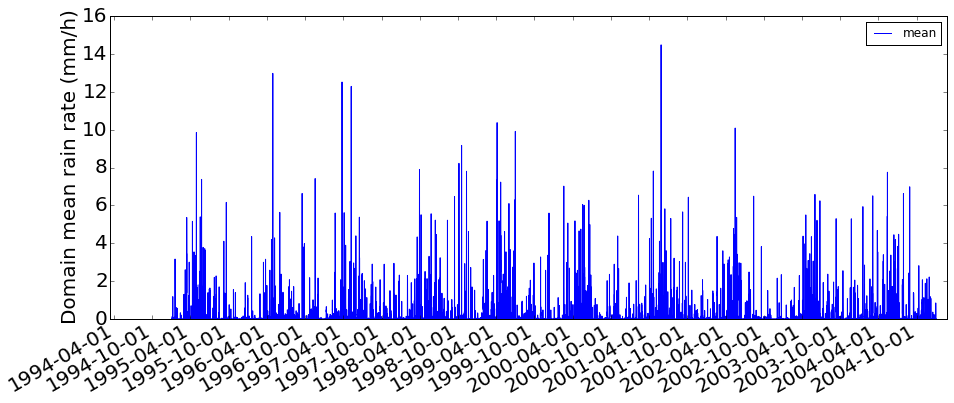

In [9]:
rain_plotter(all_times_ncep, all_rains_ncep)

<matplotlib.colorbar.Colorbar instance at 0x10abc2518>

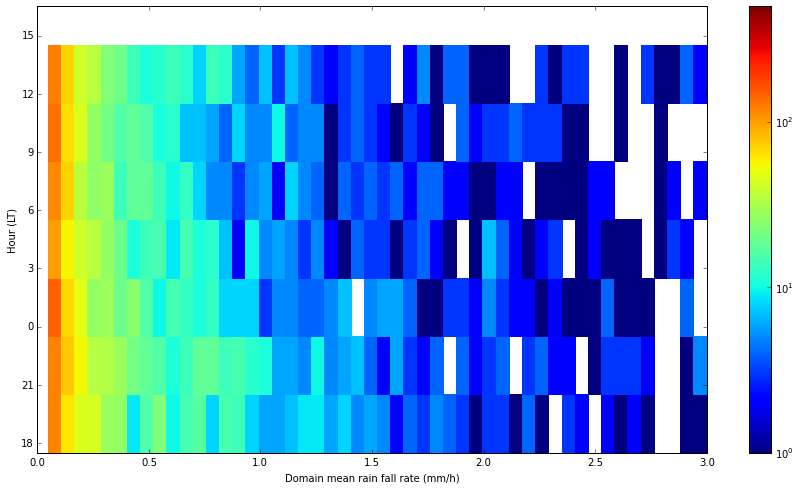

In [10]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine, hours, hist_rf, norm=LogNorm(vmin=1, vmax=500))
ax = plt.gca()
mty = plt.yticks(hours+.5, lts)
plt.ylim([0,23])
plt.ylabel('Hour (LT)')
plt.xlabel('Domain mean rain fall rate (mm/h)')
plt.colorbar()

(1, 12)

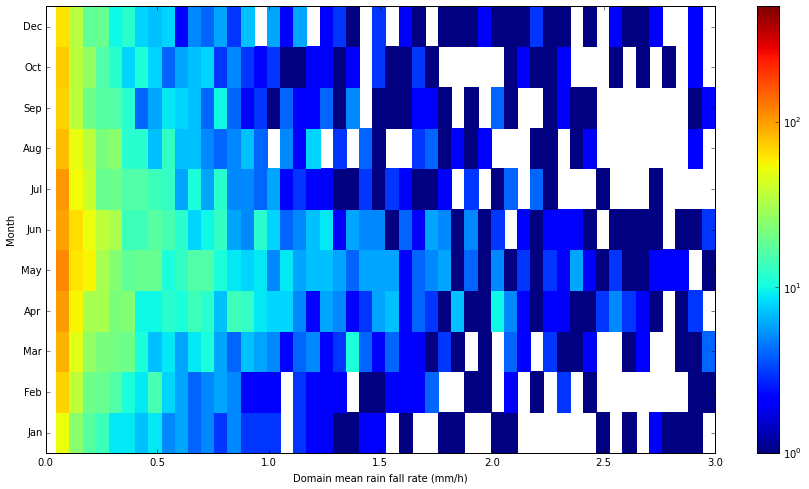

In [11]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine2, months, hist_rf_monthly, norm=LogNorm(vmin=1, vmax=500))
plt.ylabel('Month')
plt.xlabel('Domain mean rain fall rate (mm/h)')

plt.colorbar()
montext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Dec']
mty = plt.yticks(months + 0.5, montext)
plt.ylim([1,12])

In [12]:
all_rains_GFDL_Nudg, all_times_GFDL_Nudg = \
           concat_rgcm('/data/jialiwang/WRF-GFDL_Nudg/', ['rain_exp', 'rain_con'])

hist_rf, bine, (hrly, hrly50, hrly25, hrly75) = \
          hourly_stats(all_times_GFDL_Nudg, all_rains_GFDL_Nudg, hours)

hist_rf_monthly, bine2, (monthly, monthly50, monthly25, monthly75) = \
        monthly_stats(all_times_GFDL_Nudg, all_rains_GFDL_Nudg, months)

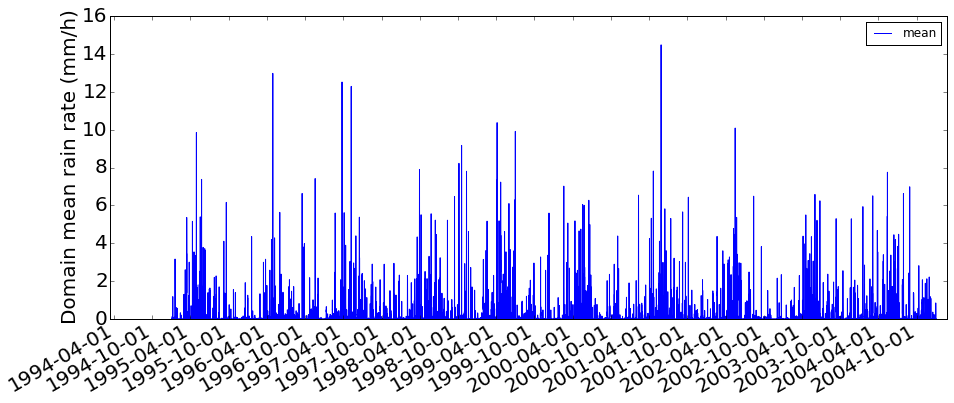

In [13]:
rain_plotter(all_times_ncep, all_rains_ncep)

<matplotlib.colorbar.Colorbar instance at 0x10bcc8560>

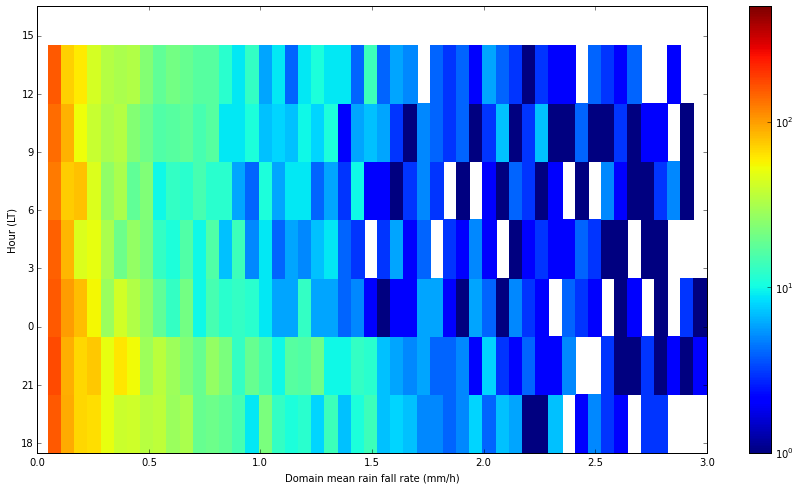

In [14]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine, hours, hist_rf, norm=LogNorm(vmin=1, vmax=500))
ax = plt.gca()
mty = plt.yticks(hours+.5, lts)
plt.ylim([0,23])
plt.ylabel('Hour (LT)')
plt.xlabel('Domain mean rain fall rate (mm/h)')
plt.colorbar()

(1, 12)

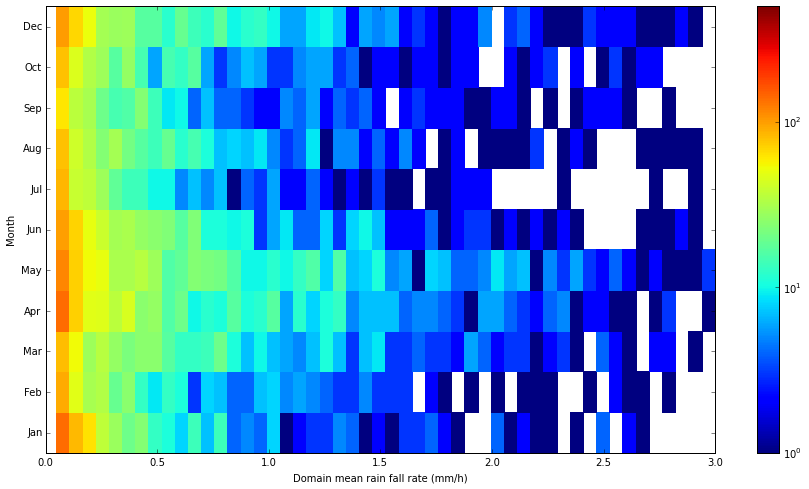

In [15]:
fig = plt.figure(figsize = [15,8])
plt.pcolormesh(bine2, months, hist_rf_monthly, norm=LogNorm(vmin=1, vmax=500))
plt.ylabel('Month')
plt.xlabel('Domain mean rain fall rate (mm/h)')

plt.colorbar()
montext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Dec']
mty = plt.yticks(months + 0.5, montext)
plt.ylim([1,12])